# Classification 2

## Exercise 5: Building our own Ensemble model

### Overview

The objective of this exercise is to build an ensemble model made up of models that we have built previously. This ensemble will be made up of:

- KNN
- Decision Tree
- Logistic Regression

### Library Imports

In [1]:
# Basic Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
# Import the relevant Scikit-learn functions and Classes as required. You may have to keep modifying this cell as you discover more
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc

## Data Ingestion

In [3]:
# Read in the CSV file saved from Exercise 1
file_path = "telco_churn.csv"
# The 1st column of the csv file should be the customer ID, which is loaded in the the Dataframe's index
input_data = pd.read_csv(file_path, index_col=0)

In [4]:
# Validate that data is as expected
input_data.head()

,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnLabel
CustomerID,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,M2M,Yes,mcheck,53.85,108.15,Yes
9237-HQITU,Female,No,No,Yes,2,Yes,No,FiberOptic,No,No,No,No,No,No,M2M,Yes,echeck,70.70,151.65,Yes
9305-CDSKC,Female,No,No,Yes,8,Yes,Yes,FiberOptic,No,No,Yes,No,Yes,Yes,M2M,Yes,echeck,99.65,820.50,Yes
7892-POOKP,Female,No,Yes,Yes,28,Yes,Yes,FiberOptic,No,No,Yes,Yes,Yes,Yes,M2M,Yes,echeck,104.80,3046.05,Yes
0280-XJGEX,Male,No,No,Yes,49,Yes,Yes,FiberOptic,No,Yes,Yes,No,Yes,Yes,M2M,Yes,transfer,103.70,5036.30,Yes


In [5]:
# Size of data - TASK: Validate that it's (7032, 20)
input_data.shape

(7032, 20)

## Feature Engineering

In [6]:
# Outcome variable
# Instead of keeping the values, we will encode as 1s and 0s using the map function
output_var_name = 'ChurnLabel'
output_var = input_data[output_var_name]
output_var = output_var.map({'Yes': 1, 'No': 0})
# Note that the map function can be run only once. You will get an error if you try to run this cell again as Yes/No are no longer valid values in this feature. 

# Count the number of rows for each outcome value
print("Row count for each outcome")
print(output_var.value_counts())

# Remove the outcome variable from the main dataframe
input_data.drop(output_var_name, axis=1, inplace=True)

Row count for each outcome
0    5163
1    1869
Name: ChurnLabel, dtype: int64


In [7]:
# Next, we want to define 3 lists for each of the data types found in our data i.e. Numerical, Categorical (more than 2 values), Binary (2 values only)

# Numerical features
num_features = [key for key in dict(input_data.dtypes) if dict(input_data.dtypes)[key] in ['int64', 'float64']]
print(num_features) # TASK: Confirm the columns based on Exercise 1

['TenureMonths', 'MonthlyCharges', 'TotalCharges']


In [8]:
# Define the 4 categorical features as a list of strings. These are the non-numerical features that do not have Yes/No values
# Categorical feature names
cat_features = ['Gender', 'InternetService', 'Contract', 'PaymentMethod']

In [9]:
# Define the binary features. Complete the steps denoted in this cell.
# 1. Get the list of non-numerical features (both categorical and binary). Hint: Add 'not' to the code from num_features

# Copy then modify the code from num_features
bin_features = [key for key in dict(input_data.dtypes) if dict(input_data.dtypes)[key] not in ['int64', 'float64']]

# 2. Remove the categorical feature names from this list
for col in cat_features:
    # Hint: There is a list method to remove an element
    bin_features.remove(col)
print(f"List of binary features: {bin_features}") # TASK: Confirm the resulting list

List of binary features: ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']


In [10]:
# Encoding the binary features. Similar to the outcome variable, we will need to convert the values of these features from Yes/No to 1/0.
# Note: As an alternative, this could have been done when building the pipeline.
# Complete the code 
for col in bin_features:
    input_data[col] = input_data[col].map({'Yes': 1, 'No': 0})

In [11]:
# Display values after encoding
input_data.head()

,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
CustomerID,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,M2M,1,mcheck,53.85,108.15
9237-HQITU,Female,0,0,1,2,1,0,FiberOptic,0,0,0,0,0,0,M2M,1,echeck,70.70,151.65
9305-CDSKC,Female,0,0,1,8,1,1,FiberOptic,0,0,1,0,1,1,M2M,1,echeck,99.65,820.50
7892-POOKP,Female,0,1,1,28,1,1,FiberOptic,0,0,1,1,1,1,M2M,1,echeck,104.80,3046.05
0280-XJGEX,Male,0,0,1,49,1,1,FiberOptic,0,1,1,0,1,1,M2M,1,transfer,103.70,5036.30


## Model Building

In [12]:
# Define preprocessing pipeline. Reminder that the binary features have already been encoded and thus only passed through
# Match the list of features to the correct encoding operation. 
# Remember to add the library imports for ColumnTransformer, StandardScaler, OneHotEncoder to the imports above
preprocess = ColumnTransformer(
    transformers=[
        ('standardscaler', StandardScaler(), num_features),
        ('onehotencoder', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'
)

In [15]:
# Define the models and their parameters: KNN  and Decision Tree from previous exercises and Logistic Regression Classifier using 
# default parameters
model_knn = make_pipeline(
     preprocess,
     KNeighborsClassifier(n_neighbors=5)
)

In [16]:
model_dt = make_pipeline(
     preprocess,
     DecisionTreeClassifier(random_state=42,
                           max_depth=3,
                           max_features=0.4,
                           min_samples_leaf=0.08)
)

In [17]:
model_lr = make_pipeline(
     preprocess,
     LogisticRegression()
)

In [18]:
clfs = [
    ('KNN', model_knn),
    ('Decision Tree', model_dt),
    ('Logistic Regression', model_lr)
]

In [19]:
# Train/Test Split
# Split the data into 70:30 train/test. Use the random_state=42
x_train, x_test, y_train, y_test = train_test_split(input_data, output_var, test_size=0.3, random_state=42)

In [20]:
# Check the dimensions of the data. TASK: Confirm as (2110, 19)
x_test.shape

(2110, 19)

In [22]:
# Train the individual models and calculate the metric individually for comparison
# Replace metric with appropriate one

for clf_name, clf in clfs:
        clf.fit(x_train, y_train)
        pred_test = clf.predict(x_test)

    # Calculate the metrics used to evaluate previous models
        f1 = f1_score(y_test, pred_test)
        print('{:s} : {:.3f}'.format(clf_name, f1)) 

KNN : 0.604
Decision Tree : 0.613
Logistic Regression : 0.645


In [23]:
model = VotingClassifier(estimators=clfs)
model.fit(x_train, y_train)

VotingClassifier(estimators=[('KNN',
                              Pipeline(memory=None,
                                       steps=[('columntransformer',
                                               ColumnTransformer(n_jobs=None,
                                                                 remainder='passthrough',
                                                                 sparse_threshold=0.3,
                                                                 transformer_weights=None,
                                                                 transformers=[('standardscaler',
                                                                                StandardScaler(copy=True,
                                                                                               with_mean=True,
                                                                                               with_std=True),
                                                                       

In [24]:
# Apply the model on the test data
pred_test = model.predict(x_test)

In [25]:
# Import the following metrics from scikit-learn in the library imports section above
# confusion_matrix, accuracy_score, precision, recall, f1_score, classification_report, roc_curve, auc
# Note that all these functions have the same parameter profile i.e. the first parameter contains the actual values while the second parameter contains the predicted values from the model.


In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_test)
print(cm)

[[1349  173]
 [ 226  362]]


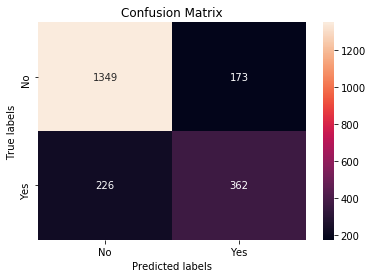

In [27]:
# Confusion Matrices typically are displayed in a graphical manner. Run this cell to display the matrix using this code snippet found online.
labels = ['No','Yes']
ax= plt.subplot()
sn.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [28]:
# Calculate the 4 following metrics using the correct function
# OPTIONAL: Calculate these metrics by hand (using the formulas in the reference blog posts) to validate the values

# 1. Accuracy = Sum of correctly predicted outcomes divided by total number of samples
accuracy = accuracy_score(y_test, pred_test)
print("Accuracy: {:.5f}".format(accuracy))

Accuracy: 0.81090


In [29]:
# 2. Precision - Of those predicted positive, how many of them are actual positive.
precision = precision_score(y_test, pred_test)
print("Precision: {:.5f}".format(precision))

Precision: 0.67664


In [30]:
# 3. Recall - how many of the actual positives our model is predicting as positives
recall = recall_score(y_test, pred_test)
print("Recall: {:.5f}".format(recall))

Recall: 0.61565


In [31]:
# 4. F1 score
f1 = f1_score(y_test, pred_test)
print("F1 Score: {:.5f}".format(f1))

F1 Score: 0.64470


In [32]:
# Alternatively, we can calculate all these metrics in one call using the classification_report function
print(classification_report(y_test, pred_test, digits=5))

              precision    recall  f1-score   support

           0    0.85651   0.88633   0.87117      1522
           1    0.67664   0.61565   0.64470       588

    accuracy                        0.81090      2110
   macro avg    0.76657   0.75099   0.75793      2110
weighted avg    0.80638   0.81090   0.80806      2110



At this point, take a step back and try to understand these numbers. 

- What do these metrics mean in the context of the problem? 
- Which error (Type 1 or Type 2) is more important for this problem? And thus which metric is more important, Precision or Recall?

In [33]:
# Compute ROC and AUC. Note that roc_curve() returns 3 values. You will only need the first 2 as input to auc() i.e. use _ as the 3rd output
fpr, tpr, _ = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

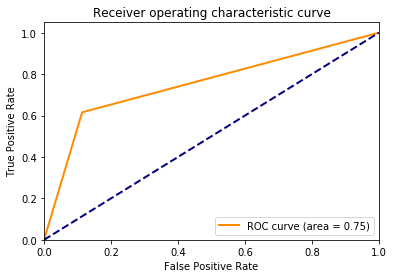

In [34]:
# Run this cell to plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

Congratulations! You have built a basic classication model. Complete the lesson quiz and proceed to the next lesson.